*italicised text*# Transforming Images with OpenCV: From Basic to Advanced Techniques
https://www.kaggle.com/code/talhabu/opencv-tutorial-from-basic-to-advanced

In [ ]:
################################################################
#              Aknowledgements                                 #
################################################################
# This notebook takes inspriration from the following work    #
# of kaggle user Black Mamba                                  #
# https://www.kaggle.com/theblackmamba31/who-is-behind-the-mask
#                                                             #
# do upvote her work                                          #
###############################################################


###############################################################
#  This noteBook contains a Transformer for image Segmentation#
###############################################################

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.jpg', '_L.jpg', mem))

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj






<>:17: SyntaxWarning: invalid escape sequence '\.'
<>:17: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1247531475.py:17: SyntaxWarning: invalid escape sequence '\.'
  maskNames.append(re.sub('\.jpg', '_L.jpg', mem))


In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels'
         , shape = 256)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/camvid/CamVid/train'

In [ ]:
framObjValidation  = LoadData( framObjValidation, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels'
         , shape = 256)

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [ ]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
## trainign our model
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 150, verbose = 0)

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask




def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')





In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

In [ ]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

In [ ]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

In [ ]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

In [ ]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

In [ ]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

In [ ]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

In [ ]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])

![OpenCV2](https://fiverr-res.cloudinary.com/images/t_main1,q_auto,f_auto/gigs/114253538/original/5f0dccf1ad82403b29ae0106e1b5911ee39c0452/code-for-you-in-python-and-opencv2-for-image-processing.jpg)


Welcome to our OpenCV tutorial notebook! In this notebook, we will explore various image processing techniques using OpenCV2 library in Python. The tutorial is designed for beginners to intermediate level users who want to learn the basics of image processing and manipulation.

We will start by learning how to perform image masking, color channels merging and splitting, and gray scale histograms. Then, we will move on to more advanced techniques such as color histograms, histogram equalization, and image blurring. We will also learn how to apply image threshold, gradient detection, and Canny edge detection for feature extraction.

In addition to these techniques, we will also explore various image transformations, including rotation, resizing, flipping, and cropping. We will also learn how to perform image operations such as translation and bitwise logical operations.

Throughout this tutorial, we will be using OpenCV2 Python libraries to implement these techniques on various images. We will also be displaying the results using matplotlib for a better understanding of the image processing techniques.

So, whether you're new to OpenCV or looking to refresh your skills, this tutorial has something for everyone. Let's dive in and explore the world of image processing!


# Loading Neccessary Libararies & Dataset

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset
img_paths = "/content/cat.jpeg"

**Preview the Image**

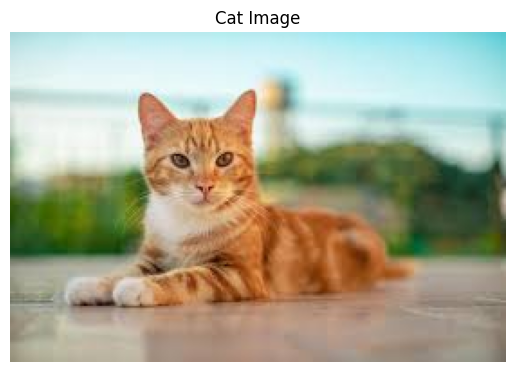

In [ ]:
# read the image using OpenCV
img = cv2.imread(img_paths)

# convert the color from BGR to RGB for displaying using matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image using matplotlib
plt.imshow(img)
plt.title('Cat Image')
plt.axis('off')
plt.show()

# Converting from RGB to Grayscale

Grayscale images are a popular format in computer vision applications as they are easier to process and require less storage space than color images. Converting a color image to grayscale involves converting the RGB (red, green, blue) color space into a single-channel grayscale image. OpenCV provides a simple and efficient way to perform this conversion using its built-in cvtColor() function. In this process, the image's color channels are weighted and combined to create a single grayscale channel that represents the image's intensity values. This technique is widely used in various computer vision applications such as object detection, image segmentation, and feature extraction. In this Kaggle notebook, we will explore how to convert an image to grayscale using OpenCV in Python.

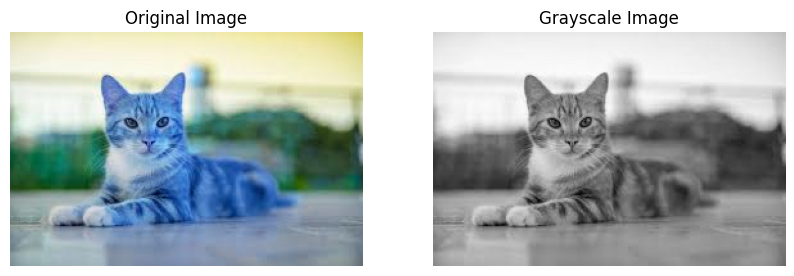

In [ ]:
# Loading the image
img = cv2.imread(img_paths)

# Converting the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Displaying the results
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(gray_img, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Image Masking

Image masking is a popular technique in computer vision that allows us to selectively modify or extract certain parts of an image based on a specific criterion. Masking is used to separate the region of interest (ROI) from the rest of the image. In OpenCV, image masking is performed using binary images where the pixels are either 0 or 255. This technique is particularly useful for various computer vision applications, including object detection, segmentation, and tracking. Masking involves creating a binary mask or overlay image that is then applied to the original image, allowing us to isolate and manipulate the specific region of interest while leaving the rest of the image untouched. In this step, we will explore how to perform image masking using OpenCV in Python.

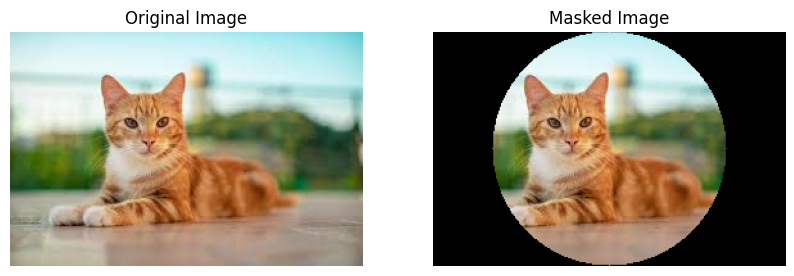

In [ ]:
# Load the image
img = cv2.imread(img_paths)

# Create a black mask with the same size as the image
mask = np.zeros_like(img)

# Define the center and radius of the circle
height, width = img.shape[:2]
center = (width // 2, height // 2)
radius = min(center[0], center[1])

# Draw a white circle in the mask
cv2.circle(mask, center, radius, (255, 255, 255), -1)

# Apply the mask to the image
masked_image = cv2.bitwise_and(img, mask)

# Display the original image with the circular mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[1].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
ax[1].set_title('Masked Image')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Image Color Channel

In digital images, color channels refer to the different color components of an image that represent primary colors such as red, green, and blue. In OpenCV, images are stored as three-dimensional arrays where each element represents the color value of a pixel, with the first two dimensions representing the spatial coordinates of the image and the third dimension representing the color channels. This allows us to manipulate each color channel independently, which can be useful in a variety of image processing tasks. Now, we will explore how to split and merge color channels in OpenCV using Python.

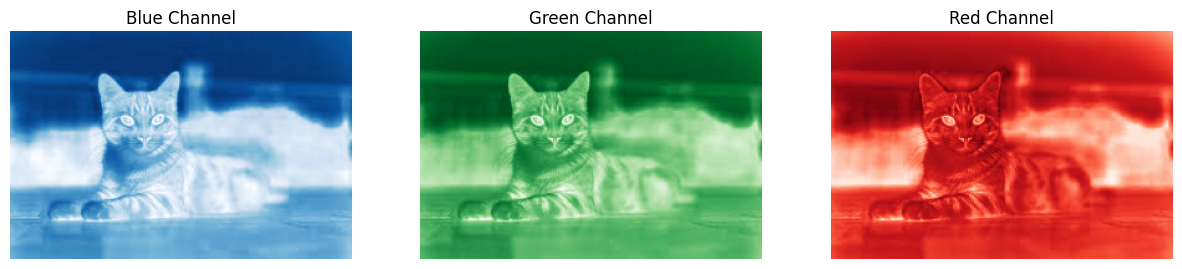

In [ ]:
# Load the image
img = cv2.imread(img_paths)

# Split the image into its color channels
b, g, r = cv2.split(img)

# Display each color channel as a separate image
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(b, cmap='Blues')
ax[0].set_title('Blue Channel')
ax[1].imshow(g, cmap='Greens')
ax[1].set_title('Green Channel')
ax[2].imshow(r, cmap='Reds')
ax[2].set_title('Red Channel')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

# Merging Images

In OpenCV, we can merge multiple images by splitting them into their individual color channels and then combining them to create a single image. This process is commonly used to add different types of effects to images, such as colorizing, tone mapping, and more. The merging of color channels can also be used for various image enhancement techniques, like color correction, contrast adjustment, and more. In this tutorial, we will explore how to merge images using OpenCV in Python.

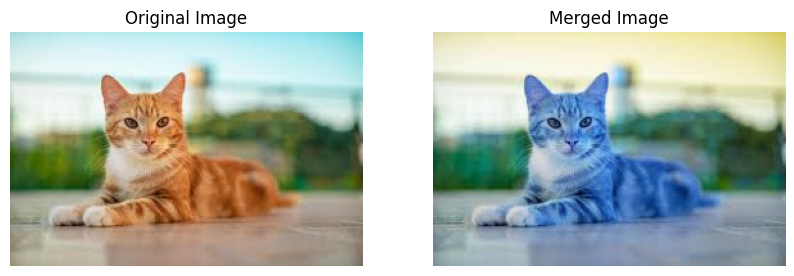

In [ ]:
# load an image from the dataset
img = cv2.imread(img_paths)

# split the image into individual color channels
b, g, r = cv2.split(img)

# merge the color channels back into an image
merged_img = cv2.merge([r, g, b])

# display the original and merged images using matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Merged Image')
ax1.axis('off')
ax2.axis('off')
plt.show()

# Grayscale Histogram

Grayscale histograms are an important tool for understanding the distribution of pixel intensities in grayscale images. Histograms provide a visual representation of the frequency of occurrence of each pixel intensity value in an image, which can be useful in image processing tasks such as thresholding, image enhancement, and segmentation. In OpenCV, grayscale histograms can be easily computed using the cv2.calcHist() function, which takes as input a grayscale image and returns a 1D array representing the histogram values. In this way, we can analyze the distribution of pixel intensities in a grayscale image and make informed decisions about how to process it.

/tmp/ipython-input-2812629530.py:7: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(gray_img.ravel(), 256, [0, 256])


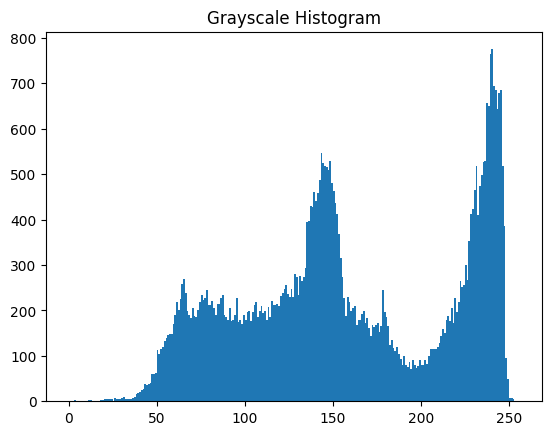

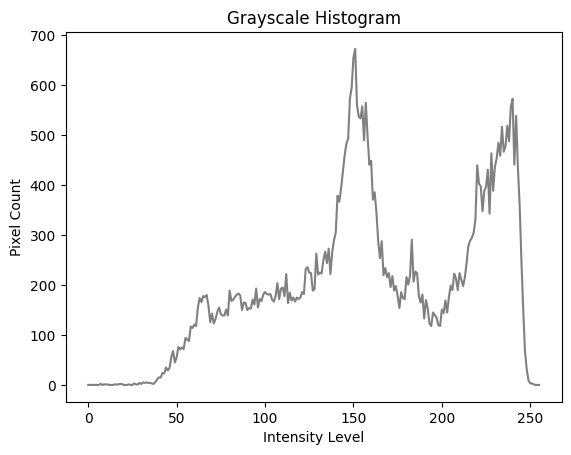

In [ ]:
# Loading the image
img = cv2.imread(img_paths)

# Plotting the histogram of a grayscale image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.hist(gray_img.ravel(), 256, [0, 256])
plt.title("Grayscale Histogram")
plt.show()

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate the grayscale histogram using cv2.calcHist()
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Display the histogram using matplotlib
plt.plot(hist, color='gray')
plt.xlabel('Intensity Level')
plt.ylabel('Pixel Count')
plt.title('Grayscale Histogram')
plt.show()

# Color Histogram

Image color histogram is a graphical representation of the distribution of colors in an image. It shows the frequency of occurrence of each color in the image, allowing us to analyze the color content of an image. OpenCV provides functions for calculating color histograms, which can be used for various applications such as image segmentation, object recognition, and color-based image retrieval. In color histograms, the colors are usually represented in the RGB or HSV color space. The RGB color space represents each color as a combination of red, green, and blue components, while the HSV color space represents each color as a combination of hue, saturation, and value components.

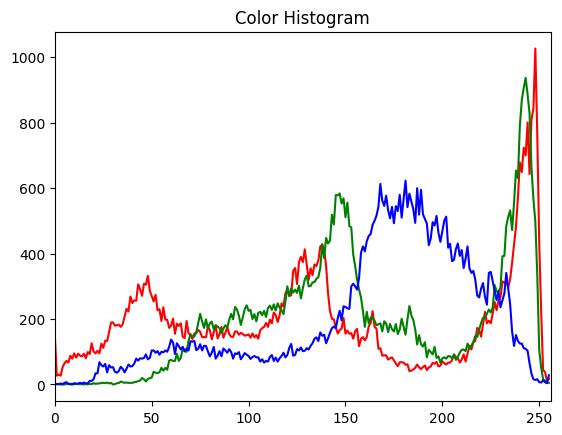

In [ ]:
# Plotting the histogram of a color image
color_img = cv2.imread(img_paths)

color = ('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([color_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
    plt.xlim([0, 256])

plt.title("Color Histogram")
plt.show()

# Histogram Equalization

Histogram equalization works by redistributing the intensity values of an image so that the pixels with low contrast get a higher contrast, resulting in an image that is easier to visualize and analyze.

In OpenCV, histogram equalization can be done using the cv2.equalizeHist() function, which takes in a grayscale image as input and returns the equalized image. This function computes a histogram of the input image and then applies the equalization algorithm to it. The equalization algorithm works by mapping the cumulative distribution function (CDF) of the input image to a linearly spaced CDF, resulting in an image with a more uniform distribution of pixel intensities.

Histogram equalization is a simple and effective method for improving the quality of images, and it is widely used in many applications such as medical imaging, satellite imaging, and computer vision.

/tmp/ipython-input-2302027230.py:17: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  axs[0, 1].hist(gray_img.ravel(), 256, [0, 256])
/tmp/ipython-input-2302027230.py:23: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  axs[1, 1].hist(eq_gray_img.ravel(), 256, [0, 256])


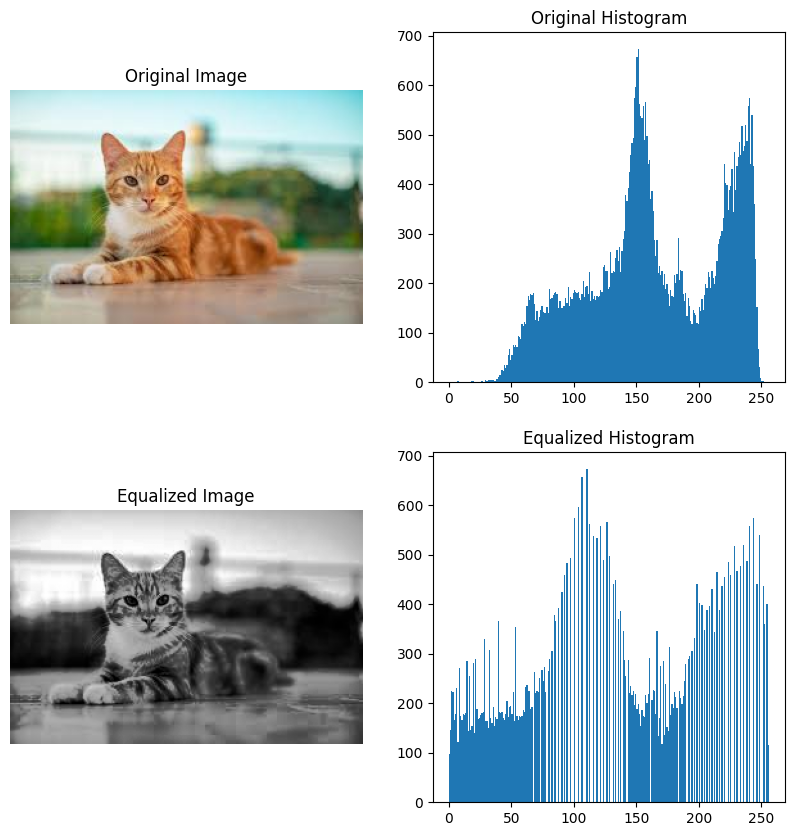

In [ ]:
# Load an image from the dataset
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Perform histogram equalization on the grayscale image
eq_gray_img = cv2.equalizeHist(gray_img)

# Plot the images and histograms
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img)
axs[0, 0].set_title('Original Image')

axs[0, 1].hist(gray_img.ravel(), 256, [0, 256])
axs[0, 1].set_title('Original Histogram')

axs[1, 0].imshow(eq_gray_img, cmap='gray')
axs[1, 0].set_title('Equalized Image')

axs[1, 1].hist(eq_gray_img.ravel(), 256, [0, 256])
axs[1, 1].set_title('Equalized Histogram')
axs[0, 0].axis('off')
axs[1, 0].axis('off')
plt.show()

# Image Blurring

Image blurring is a fundamental technique used in image processing to reduce image noise or smooth out sharp edges. Blurring can also be used to hide certain details in an image or make it less distinguishable. OpenCV provides a variety of image blurring techniques, including averaging, Gaussian blurring, and median blurring. These techniques work by applying a filter to the image, which replaces each pixel value with a weighted average of the neighboring pixel values. The size and shape of the filter can be adjusted to control the degree of blurring. Blurring can be particularly useful in preparing images for further processing, such as edge detection or feature extraction.

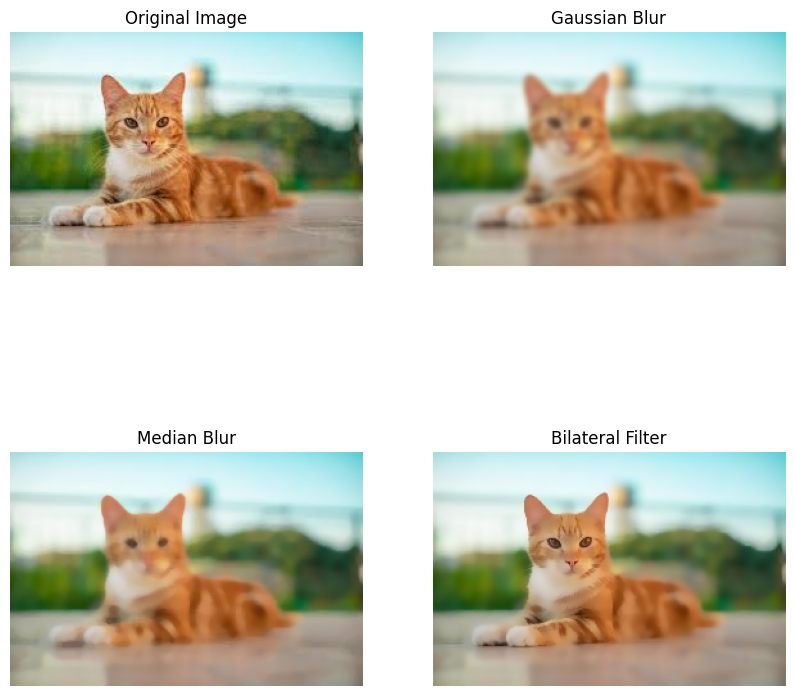

In [ ]:
# Load image from dataset
img = cv2.imread(img_paths)

# Create a figure to display the images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display the original image
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')

# Apply a Gaussian blur to the image
gaussian_blur = cv2.GaussianBlur(img, (11, 11), 0)
axs[0, 1].imshow(cv2.cvtColor(gaussian_blur, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Gaussian Blur')

# Apply a median blur to the image
median_blur = cv2.medianBlur(img, 7)
axs[1, 0].imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Median Blur')

# Apply a bilateral filter to the image
bilateral_filter = cv2.bilateralFilter(img, 9, 75, 75)
axs[1, 1].imshow(cv2.cvtColor(bilateral_filter, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Bilateral Filter')
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
plt.show()

# Thresholding Image

Image thresholding is a commonly used image processing technique in computer vision and image analysis. It is a process of transforming a grayscale or color image into a binary image, where the pixels are either classified as black or white based on a certain threshold value. The thresholding technique is used to extract important information from an image, such as edges, contours, and shapes. OpenCV provides various thresholding techniques, including Simple Thresholding, Adaptive Thresholding, and Otsu's Thresholding, which can be used to enhance image features and extract the relevant information needed for further analysis. These techniques are widely used in various applications, such as object detection, image segmentation, and image recognition. In this tutorial, we will explore different thresholding techniques and how to apply them using OpenCV in Python.

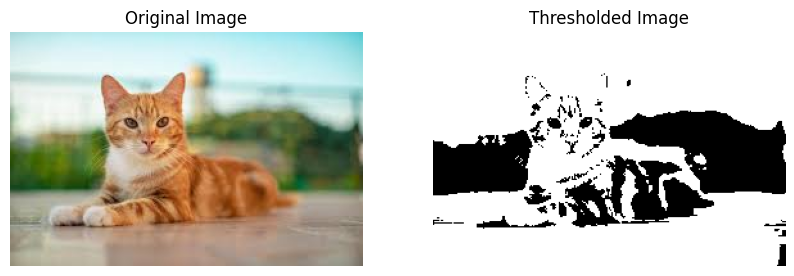

In [ ]:
# Load image from dataset
img = cv2.imread(img_paths)

# Convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding using a threshold value of 127
ret, thresh = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(thresh, cmap="gray")
axs[1].set_title("Thresholded Image")
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Image Gradient Detection

Image gradient detection is a fundamental image processing technique that plays a significant role in computer vision applications such as edge detection, image segmentation, and feature extraction. Gradient represents the rate of change in pixel intensity across the image, and detecting gradients helps to identify edges and boundaries in an image. OpenCV provides various functions to compute image gradients, such as Sobel, Scharr, Laplacian, and Canny edge detection algorithms. These algorithms use different approaches to calculate gradients and can be selected based on the image's characteristics and the specific task requirements. In this way, image gradient detection can greatly enhance the image processing capabilities of computer vision systems.

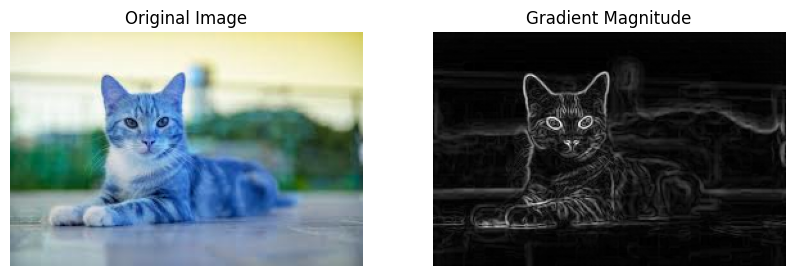

In [ ]:
# Reading the image
img = cv2.imread(img_paths)

# Converting the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Computing the gradient in the x direction using the Scharr operator
sobel_x = cv2.Scharr(gray, cv2.CV_64F, 1, 0)

# Computing the gradient in the y direction using the Scharr operator
sobel_y = cv2.Scharr(gray, cv2.CV_64F, 0, 1)

# Computing the gradient magnitude
grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

# Normalizing the gradient magnitude to the range [0, 255]
grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Displaying the results
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[1].imshow(grad_mag_norm, cmap="gray")
axs[1].set_title("Gradient Magnitude")
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Canny Edge Detection

Image Canny Edge Detection is a popular technique used in image processing to detect edges in an image. It is named after its inventor John F. Canny. This technique uses a multi-stage algorithm to detect a wide range of edges in the image. The Canny Edge Detection algorithm first applies a Gaussian filter to the image to remove noise and then calculates the intensity gradients in the image. These gradients are then used to determine the edges in the image. The Canny Edge Detection technique is highly effective in detecting edges in images with low contrast or high levels of noise. In this technique, the edges detected are very precise and can be used in various applications such as object recognition, tracking, and segmentation. OpenCV provides a simple and efficient implementation of the Canny Edge Detection algorithm, making it accessible to developers and researchers alike.

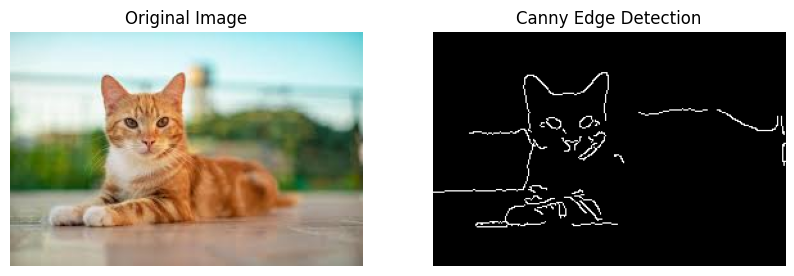

In [ ]:
# Read the image
img = cv2.imread(img_paths)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, 100, 200)

# Display the original image and the edges detected image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(edges, cmap='gray')
axs[1].set_title('Canny Edge Detection')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Image with Contours

Image contours are an essential concept in computer vision and image processing. They are defined as the boundaries of the objects present in an image. The contours can be used to extract various features from the image, such as shape, size, and position. The contour detection algorithm works by finding the points that define the object's boundaries, and these points are then connected to form the contour. OpenCV provides various functions for contour detection, and these contours can be used for a variety of applications, such as object detection, recognition, and tracking. In this tutorial, we will explore the concepts of image contours and how to use OpenCV to extract them from an image. We will also cover some advanced topics, such as contour approximation and hierarchy, and demonstrate how to use contours for object detection and recognition.

In [ ]:
# Load the image paths
img_paths = "/content/cat1.jpg"

# Read the image and convert to grayscale
img = cv2.imread(img_paths)

# Check if the image was loaded successfully
if img is not None:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to obtain a binary image
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    img_contours = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 2) # Use img.copy() to avoid drawing on the original image

    # Display the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[1].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Image with Contours")
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()
else:
    print(f"Error loading image from: {img_paths}")

Error loading image from: /content/cat1.jpg


# Image Transformation

Image transformation is a technique of modifying the appearance of an image by applying mathematical operations on the pixels. These operations can change the size, orientation, shape, and perspective of the image. OpenCV provides a set of functions that allow us to transform images using various techniques such as rotation, resizing, flipping, and cropping. Image transformation is a crucial step in image processing and computer vision as it allows us to preprocess images before applying further analysis techniques. In this tutorial, we will explore various image transformation techniques using OpenCV in Python.

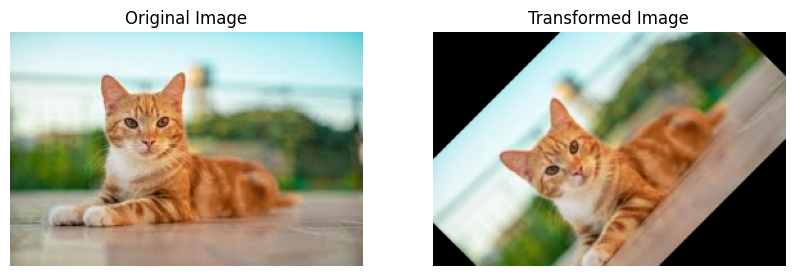

In [ ]:
# Read the image
img_path = "/content/cat.jpeg"
img = cv2.imread(img_path)

# Define the transformation matrix (e.g. rotation, translation, scaling)
M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), 45, 1) # 45 degree rotation with scale=1

# Apply the transformation to the image
transformed_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("Transformed Image")
axs[0].axis('off')
axs[1].axis('off')
plt.show()

**Image Shifting**

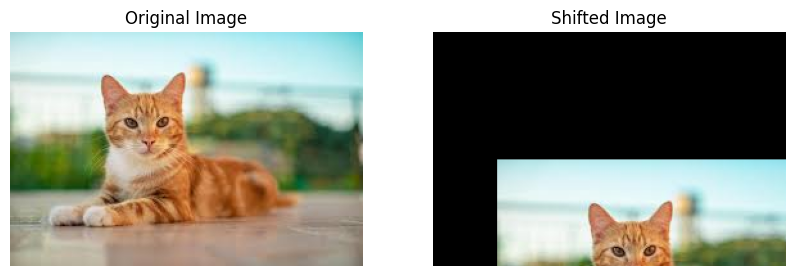

In [ ]:
# Read the image
img = cv2.imread(img_path)

# Define the translation values
translationX = 50
translationY = 100

# Define the transformation matrix
modifiedImage = np.float32([[1, 0, translationX],
                            [0, 1, translationY]])

# Apply the transformation to the image
imageShift = cv2.warpAffine(img, modifiedImage,
                            (img.shape[1], img.shape[0]))

# Show the original and shifted images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(cv2.cvtColor(imageShift, cv2.COLOR_BGR2RGB))
ax[1].set_title("Shifted Image")
ax[0].axis('off')
ax[1].axis('off')
plt.show()


**Image Rotation**

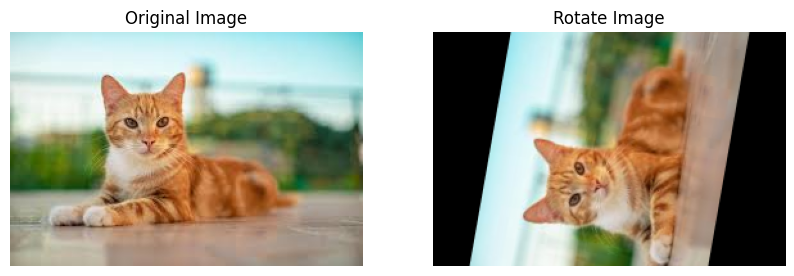

In [ ]:
# Read the image
img = cv2.imread(img_path)

# Define the rotation angle in degrees and the scaling factor
angle = 80
scale = 1

# Read the image
img = cv2.imread(img_path)

# Get the dimensions of the image
height, width = img.shape[:2]

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, scale)

# Apply the rotation to the image
rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))

# Display the original and rotated images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("Rotate Image")
axs[0].axis('off')
axs[1].axis('off')
plt.show()


**Image Resizing**

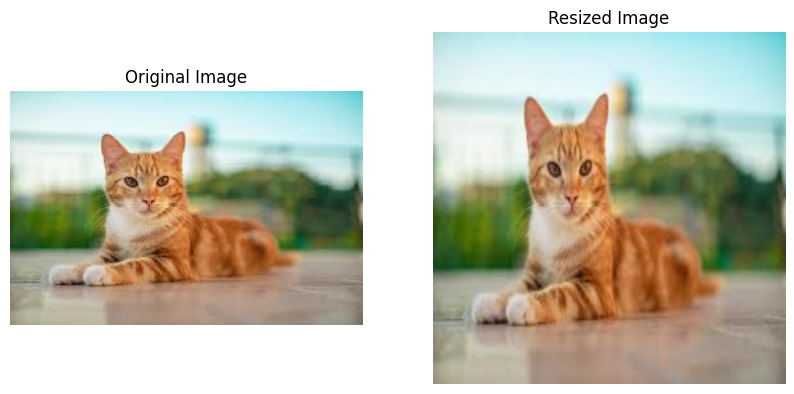

In [ ]:
# Define the new dimensions for the resized image
new_width = 500
new_height = 500

# Read the image
img = cv2.imread(img_path)

# Get the original dimensions of the image
height, width, _ = img.shape

# Calculate the scale factor for resizing
scale_x = new_width / width
scale_y = new_height / height

# Resize the image
resized_img = cv2.resize(img, (new_width, new_height))

# Display the original and rotated images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("Resized Image")
axs[0].axis('off')
axs[1].axis('off')
plt.show()


**Image Flippping**

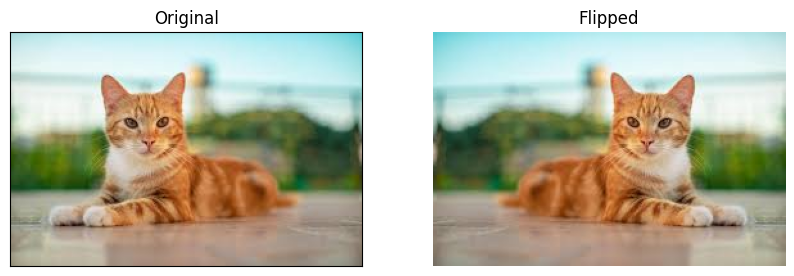

In [ ]:
# Loop over the images and flip them horizontally
img = cv2.imread(img_path)

    # Flip the image horizontally using cv2.flip()
flipped_img = cv2.flip(img, 1)

    # Display the original and flipped images side by side using matplotlib
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(flipped_img, cv2.COLOR_BGR2RGB))
plt.title('Flipped')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

**Image Cropping**

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


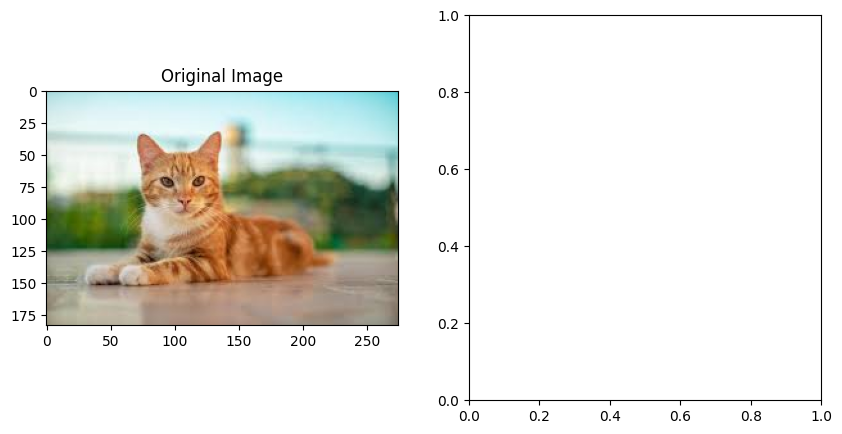

In [ ]:
 # Read the image
img = cv2.imread(img_path)

# Define the coordinates of the top left and bottom right corners of the crop
x1, y1, x2, y2 =200, 200, 600, 600

# Crop the image
cropped_img = img[y1:y2, x1:x2]

# Show the original and cropped images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
ax[1].set_title("Cropped Image")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Morphological Operations

Image Morphological Operations are a set of image processing techniques that are used to analyze and manipulate the shape and structure of an image. These operations are based on mathematical morphology, which is the study of the shape and structure of objects. Morphological operations are often used in image processing to perform tasks such as noise reduction, image enhancement, and edge detection. The operations are applied to a binary image, which is an image that consists of only two colors, typically black and white. The basic operations in morphological operations are erosion and dilation. Erosion shrinks the white regions of an image, while dilation expands them. Other operations such as opening, closing, and gradient are also commonly used. These operations are useful in many applications such as image segmentation, feature extraction, and object recognition. OpenCV provides a set of functions to perform morphological operations on images.

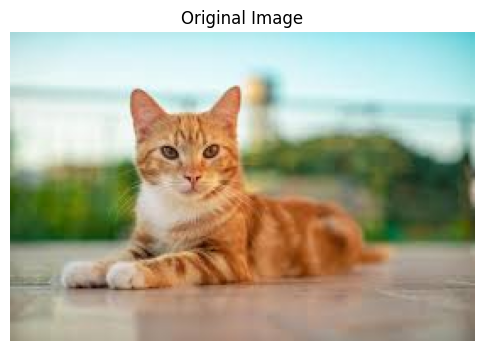

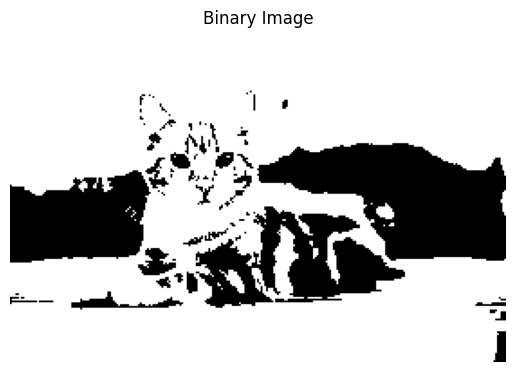

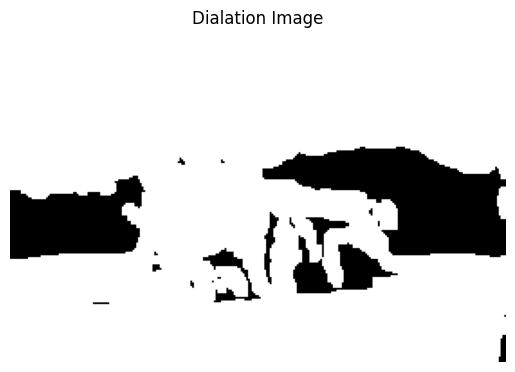

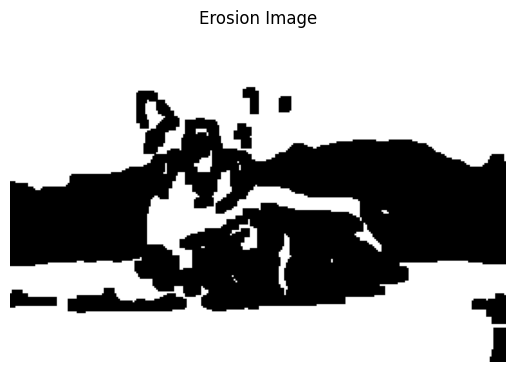

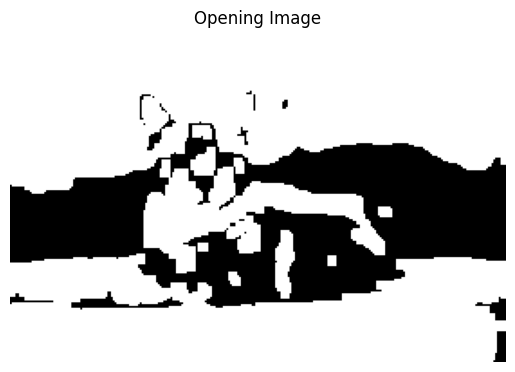

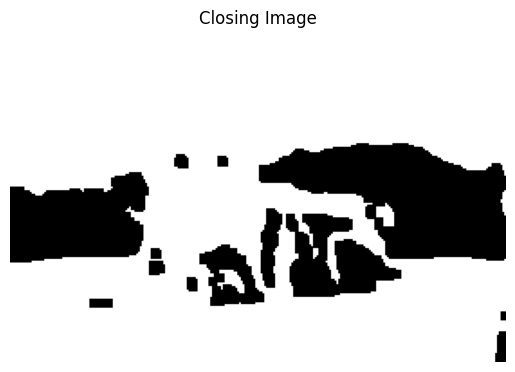

In [ ]:
img_path = "/content/cat.jpeg"

# Read the image
img = cv2.imread(img_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to obtain a binary image
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Define the structuring element
kernel = np.ones((5,5), np.uint8)

# Apply dilation to the binary image
dilation = cv2.dilate(binary, kernel, iterations=1)

# Apply erosion to the binary image
erosion = cv2.erode(binary, kernel, iterations=1)

# Apply opening to the binary image
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Apply closing to the binary image
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Display the original image and processed images using matplotlib
fig = plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

plt.imshow(dilation, cmap='gray')
plt.title('Dialation Image')
plt.axis('off')
plt.show()

plt.imshow(erosion, cmap='gray')
plt.title('Erosion Image')
plt.axis('off')
plt.show()

plt.imshow(opening, cmap='gray')
plt.title('Opening Image')
plt.axis('off')
plt.show()

plt.imshow(closing, cmap='gray')
plt.title('Closing Image')
plt.axis('off')
plt.show()